In [1]:
import numpy as np
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import h5py
import astropy.cosmology as cosmo
import astropy.units as u
from astropy.cosmology import Planck15
import matplotlib.pyplot as plt
import json
import glob
import re

We'll additionally be reweighting the default LALInference mass and redshift priors with more astrophysically-motivated priors. The LALInference prior is uniform in *luminosity* distance, and uniform in *detector-frame* component masses. This corresponds to:

\begin{equation}
p_\mathrm{lal}(z) \propto (1+z)^2 D_L^2(z) \left( D_c(z) + \frac{c(1+z)}{H(z)}\right),
\end{equation}

where $D_L(z)$ and $D_c(z)$ are the luminosity and comoving distance at redshift $z$, respectively, and $H(z)$ is the Hubble parameter at $z$.

We'll reweight to a prior that assumes the (source-frame) comoving merger rate density evolves as $(1+z)^{2.7}$

\begin{equation}
p_\mathrm{astro}(z) \propto \frac{1}{1+z} \left(1+z\right)^{2.7} \frac{dV_c}{dz}
\end{equation}

In [4]:
c = 3.0e8          # m/s
H_0 = 67270.0      # m/s/MPc
Omega_M = 0.3156 # unitless
Omega_Lambda = 1.0-Omega_M

def Hz(z):
    return H_0*np.sqrt(Omega_M*(1.+z)**3.+Omega_Lambda)

def calculate_pLAL(z, dl):
    dc = dl/(1.+z) # comoving distance 
    pLAL = np.power(1.+z,2.)*np.power(dl,2.)*(dc+c*(1.+z)/Hz(z))
    return pLAL

def calculate_pASTRO(z, dl):
    dc = dl/(1.+z) # comoving distance 
    dVc_dz = 4*np.pi*c*(dc**2.)/Hz(z) # comoving volume 
    pASTRO = np.power(1.+z,1.7)*dVc_dz
    return pASTRO

def Calculate_Xeff(m1, m2, a1, a2, costilt1, costilt2):
    Xeff = (m1*a1*costilt1 + m2*a2*costilt2)/(m1+m2)
    return Xeff

For later use, we'll want to build an interpolant between luminosity distance and redshift:

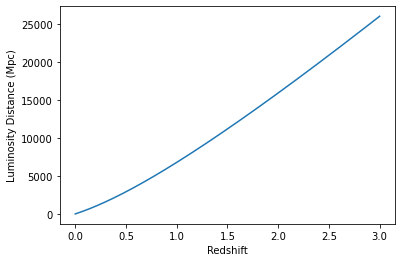

In [5]:
zs_ref = np.linspace(0.,3.,1000)
DL_ref = Planck15.luminosity_distance(zs_ref).to(u.Mpc).value

fig,ax = plt.subplots()
ax.plot(zs_ref,DL_ref)
ax.set_xlabel('Redshift')
ax.set_ylabel('Luminosity Distance (Mpc)')
plt.show()

In [6]:
from scipy.special import spence as PL

def Di(z):
    return PL(1.-z+0j)

def chi_effective_prior_from_isotropic_spins(q,aMax,xs):

    # Ensure that `xs` is an array and take absolute value
    xs = np.reshape(np.abs(xs),-1)

    # Set up various piecewise cases
    pdfs = np.zeros(xs.size,dtype=complex)
    caseA = (xs<aMax*(1.-q)/(1.+q))*(xs<q*aMax/(1.+q))
    caseB = (xs<aMax*(1.-q)/(1.+q))*(xs>=q*aMax/(1.+q))
    caseC = (xs>=aMax*(1.-q)/(1.+q))*(xs<q*aMax/(1.+q))
    caseD = (xs>=aMax*(1.-q)/(1.+q))*(xs<aMax/(1.+q))*(xs>=q*aMax/(1.+q))
    caseE = (xs>=aMax*(1.-q)/(1.+q))*(xs>=aMax/(1.+q))*(xs<aMax)
    caseF = (xs>=aMax)

    # Select relevant effective spins
    x_A = xs[caseA]
    x_B = xs[caseB]
    x_C = xs[caseC]
    x_D = xs[caseD]
    x_E = xs[caseE]

    pdfs[caseA] = (1.+q)/(4.*q*aMax**2)*(
                    q*aMax*(4.+2.*np.log(aMax) - np.log(q**2*aMax**2 - (1.+q)**2*x_A**2))
                    - 2.*(1.+q)*x_A*np.arctanh((1.+q)*x_A/(q*aMax))
                    + (1.+q)*x_A*(Di(-q*aMax/((1.+q)*x_A)) - Di(q*aMax/((1.+q)*x_A)))
                    )

    pdfs[caseB] = (1.+q)/(4.*q*aMax**2)*(
                    4.*q*aMax
                    + 2.*q*aMax*np.log(aMax)
                    - 2.*(1.+q)*x_B*np.arctanh(q*aMax/((1.+q)*x_B))
                    - q*aMax*np.log((1.+q)**2*x_B**2 - q**2*aMax**2)
                    + (1.+q)*x_B*(Di(-q*aMax/((1.+q)*x_B)) - Di(q*aMax/((1.+q)*x_B)))
                    )

    pdfs[caseC] = (1.+q)/(4.*q*aMax**2)*(
                    2.*(1.+q)*(aMax-x_C)
                    - (1.+q)*x_C*np.log(aMax)**2.
                    + (aMax + (1.+q)*x_C*np.log((1.+q)*x_C))*np.log(q*aMax/(aMax-(1.+q)*x_C))
                    - (1.+q)*x_C*np.log(aMax)*(2. + np.log(q) - np.log(aMax-(1.+q)*x_C))
                    + q*aMax*np.log(aMax/(q*aMax-(1.+q)*x_C))
                    + (1.+q)*x_C*np.log((aMax-(1.+q)*x_C)*(q*aMax-(1.+q)*x_C)/q)
                    + (1.+q)*x_C*(Di(1.-aMax/((1.+q)*x_C)) - Di(q*aMax/((1.+q)*x_C)))
                    )

    pdfs[caseD] = (1.+q)/(4.*q*aMax**2)*(
                    -x_D*np.log(aMax)**2
                    + 2.*(1.+q)*(aMax-x_D)
                    + q*aMax*np.log(aMax/((1.+q)*x_D-q*aMax))
                    + aMax*np.log(q*aMax/(aMax-(1.+q)*x_D))
                    - x_D*np.log(aMax)*(2.*(1.+q) - np.log((1.+q)*x_D) - q*np.log((1.+q)*x_D/aMax))
                    + (1.+q)*x_D*np.log((-q*aMax+(1.+q)*x_D)*(aMax-(1.+q)*x_D)/q)
                    + (1.+q)*x_D*np.log(aMax/((1.+q)*x_D))*np.log((aMax-(1.+q)*x_D)/q)
                    + (1.+q)*x_D*(Di(1.-aMax/((1.+q)*x_D)) - Di(q*aMax/((1.+q)*x_D)))
                    )

    pdfs[caseE] = (1.+q)/(4.*q*aMax**2)*(
                    2.*(1.+q)*(aMax-x_E)
                    - (1.+q)*x_E*np.log(aMax)**2
                    + np.log(aMax)*(
                        aMax
                        -2.*(1.+q)*x_E
                        -(1.+q)*x_E*np.log(q/((1.+q)*x_E-aMax))
                        )
                    - aMax*np.log(((1.+q)*x_E-aMax)/q)
                    + (1.+q)*x_E*np.log(((1.+q)*x_E-aMax)*((1.+q)*x_E-q*aMax)/q)
                    + (1.+q)*x_E*np.log((1.+q)*x_E)*np.log(q*aMax/((1.+q)*x_E-aMax))
                    - q*aMax*np.log(((1.+q)*x_E-q*aMax)/aMax)
                    + (1.+q)*x_E*(Di(1.-aMax/((1.+q)*x_E)) - Di(q*aMax/((1.+q)*x_E)))
                    )

    pdfs[caseF] = 0.

    return np.real(pdfs)

In [7]:
O1O2_events = ['GW151012', 'GW170608', 'GW170729', 'GW151226', 'GW170814', 'GW150914', 'GW170104', 'GW170809', 'GW170818', 'GW170823']
for key in O1O2_events:
    
    # load samples
    BBH_post = h5py.File('GWTC-1_sample_release/{0}_GWTC-1.hdf5'.format(key), 'r')['Overall_posterior']
    m1_DF = BBH_post['m1_detector_frame_Msun']
    m2_DF = BBH_post['m2_detector_frame_Msun']
    DL = BBH_post['luminosity_distance_Mpc']
    a1 = BBH_post['spin1']
    a2 = BBH_post['spin2']
    cost1 = BBH_post['costilt1']
    cost2 = BBH_post['costilt2']
    Xeff = Calculate_Xeff(m1_DF,m2_DF,a1,a2,cost1,cost2)
    
    # Downselect to a reasonable number of samples
    nSamps = min(3000,DL.size)
    sampleDraws = np.random.choice(np.arange(DL.size),size=nSamps,replace=False)
    m1_DF = m1_DF[sampleDraws]
    m2_DF = m2_DF[sampleDraws]
    DL = DL[sampleDraws]
    Xeff = Xeff[sampleDraws]
    a1 = a1[sampleDraws]
    a2 = a2[sampleDraws]
    cost1 = cost1[sampleDraws]
    cost2 = cost2[sampleDraws]
        
    print("##### {0}\t{1}".format(key,nSamps))
    
    print(np.max(a1),np.max(a2))
    
    # Mass ratio
    q = m2_DF/m1_DF
    
    Xeff_priors = np.zeros(q.size)
    for i in range(q.size):
        
        #ref_xeff_ps = [interp(Xeff[i]) for interp in reference_chiEff_interps]
        #xeff_1d = UnivariateSpline(reference_qs,ref_xeff_ps,k=3,s=0.1)
        #Xeff_priors[i] = xeff_1d(q[i])
        Xeff_priors[i] = chi_effective_prior_from_isotropic_spins(q[i],1.,Xeff[i])[0]

    # Redshift and mass priors
    z = np.interp(DL,DL_ref,zs_ref)
    Dc = DL/(1.+z)
    pAstro = calculate_pASTRO(z,DL)
    pAstro[pAstro<0] = 0 # if pASTRO < 0, make pASTRO = 0
    p_LAL = calculate_pLAL(z, DL)

    weights = pAstro/p_LAL
        
    preprocDict = {'z':z,\
                        'weights':weights,\
                        'm1':m1_DF/(1.+z),\
                        'm2':m2_DF/(1.+z),\
                        'Xeff':Xeff,\
                        'Xeff_priors':Xeff_priors,\
                        'a1':a1,\
                        'a2':a2,\
                        'cost1':cost1,\
                        'cost2':cost2
                       }
    np.save('preprocessed-single-events-sanityCheck/{0}.npy'.format(key),preprocDict)

##### GW151012	3000
0.9897470178991471 0.9896384391496096
##### GW170608	3000
0.9889473441307614 0.9899857010578526
##### GW170729	3000
0.9896893139819274 0.9899992906052512
##### GW151226	3000
0.989634532239877 0.9898798923355079
##### GW170814	3000
0.9951040516136314 0.9963946859887189
##### GW150914	3000
0.9898524826445978 0.9898410498719866
##### GW170104	3000
0.9898989966251264 0.9898231529527597
##### GW170809	3000
0.9857757813170925 0.9892808094149222
##### GW170818	3000
0.9895849147765335 0.9896471074071796
##### GW170823	3000
0.9886574319099788 0.9898153957722852


Loop across O1 and O2 events. We'll want to compute and store:
* Chi-effective posterior
* Chi-p posterior
* Chi-effective prior evaluated at posterior values
* Chi-p prior evaluated at posterior values
* Weights used to convert from LALInference to astrophysical mass/redshift priors

In [8]:
O3_events = [
'S190408an',
'S190412m',
'S190413ac',
'S190413i',
'S190421ar',
'S190424ao',
'S190503bf',
'S190512at',
'S190513bm',
'S190514n',
'S190517h',
'S190519bj',
'S190521g',
'S190521r',
'S190527w',
'S190602aq',
'S190620e',
'S190630ag',
'S190701ah',
'S190706ai',
'S190707q',
'S190708ap',
'S190720a',
'S190727h',
'S190728q',
'S190731aa',
'S190803e',
'S190814bv',
'S190828j',
'S190828l',
'S190910s',
'S190915ak',
'S190924h',
'S190929d',
'S190930s']

In [9]:
with open('names.json','r') as jf:
    mappings = json.load(jf)
    
S_to_AB = {v:k for k,v in mappings['SNAME'].items()}
S_to_full = {k:mappings['FULLNAME'][v] for k,v in S_to_AB.items()}

In [10]:
sampleRelease = "./all_posterior_samples"
for key in O3_events:
        
    # Load samples
    f = h5py.File('{0}/{1}.h5'.format(sampleRelease,S_to_full[key]),'r')
    BBH_post_samples = f['PrecessingSpinIMRHM']['posterior_samples']

    m1_SF = np.squeeze(BBH_post_samples['mass_1_source'])
    m2_SF = np.squeeze(BBH_post_samples['mass_2_source'])
    DL = np.squeeze(BBH_post_samples['luminosity_distance'])
    z = np.squeeze(BBH_post_samples['redshift'])
    a1 = np.squeeze(BBH_post_samples['a_1'])
    a2 = np.squeeze(BBH_post_samples['a_2'])
    cost1 = np.squeeze(BBH_post_samples['cos_tilt_1'])
    cost2 = np.squeeze(BBH_post_samples['cos_tilt_2'])
    Xeff = Calculate_Xeff(m1_SF,m2_SF,a1,a2,cost1,cost2)
    
    print(np.max(a1),np.max(a2))

    f.close()   
            
    # Downselect to a reasonable number of samples
    nSamps = min(3000,DL.size)
    sampleDraws = np.random.choice(np.arange(DL.size),size=nSamps,replace=False)
    m1_SF = m1_SF[sampleDraws]
    m2_SF = m2_SF[sampleDraws]
    DL = DL[sampleDraws]
    z = z[sampleDraws]
    Xeff = Xeff[sampleDraws]
    a1 = a1[sampleDraws]
    a2 = a2[sampleDraws]
    cost1 = cost1[sampleDraws]
    cost2 = cost2[sampleDraws]
    
    print(key,nSamps)
    
    # Mass ratio
    q = m2_SF/m1_SF
    
    Xeff_priors = np.zeros(q.size)
    for i in range(q.size):
        Xeff_priors[i] = chi_effective_prior_from_isotropic_spins(q[i],1.,Xeff[i])[0]

    # Redshift and mass priors
    Dc = DL/(1.+z)
    pAstro = calculate_pASTRO(z,DL)
    pAstro[pAstro<0] = 0 # if pASTRO < 0, make pASTRO = 0
    p_LAL = calculate_pLAL(z, DL)

    weights = pAstro/p_LAL
    
    preprocDict = {'z':z,\
                        'weights':weights,\
                        'm1':m1_SF,\
                        'm2':m2_SF,\
                        'Xeff':Xeff,\
                        'Xeff_priors':Xeff_priors,\
                        'a1':a1,\
                        'a2':a2,\
                        'cost1':cost1,\
                        'cost2':cost2
                       }
    np.save('preprocessed-single-events-sanityCheck/{0}.npy'.format(key),preprocDict)

0.9984527214224906 0.9994415584723371
S190408an 3000
0.9424569281527027 0.9998843213512595
S190412m 3000
0.9997272500676013 0.999971450037331
S190413ac 3000
0.9997497759882384 0.9999800113072943
S190413i 3000
0.9998056688330601 0.9999758090623824
S190421ar 3000
0.9999971585589158 0.9999783976365202
S190424ao 3000
0.9999384536184246 0.9998263607589885
S190503bf 3000
0.9982192887198766 0.9995412231342491
S190512at 3000
0.999915007960355 0.9999996986273785
S190513bm 3000
0.9997747696628614 0.9999892166529751
S190514n 3000
0.999986263962 0.999970706716
S190517h 3000
0.999979877196 0.999987442488
S190519bj 3000
0.9999985968 0.999953494555
S190521g 3000
0.999522296529 0.999551881323
S190521r 3000
0.9998091938904804 0.9999077402744292
S190527w 3000
0.99996269948 0.999992886019
S190602aq 3000
0.999994039925 0.999962414544
S190620e 3000
0.996685012466 0.999965785563
S190630ag 3000
0.999981208937 0.999992178649
S190701ah 3000
0.9999551042910001 0.999944920553
S190706ai 3000
0.9879590406347885 0.

In [11]:
sampleDict = {}
singleEvents = glob.glob('./preprocessed-single-events-sanityCheck/*')
for eventFile in singleEvents:
    
    key = re.split('\/|\.',eventFile)[-2]
    if key!='S190814bv':
        dataDict = np.load(eventFile,allow_pickle=True)[()]
        sampleDict[key] = dataDict

import pickle
print(len(sampleDict))
with open('sampleDict_sanityCheck.pickle','wb') as testfile:
    pickle.dump(sampleDict,testfile,protocol=2)

44


In [12]:
sampleDict_w190814 = {}
singleEvents = glob.glob('./preprocessed-single-events-sanityCheck/*')
for eventFile in singleEvents:
    
    key = re.split('\/|\.',eventFile)[-2]
    dataDict = np.load(eventFile,allow_pickle=True)[()]
    sampleDict_w190814[key] = dataDict

print(len(sampleDict_w190814))
with open('sampleDict_w190814_sanityCheck.pickle','wb') as testfile:
    pickle.dump(sampleDict_w190814,testfile,protocol=2)

45
